# Blind Source Separation 



### Task 
The task consists in decomposing an image obtained as a sum of a two images img1 and img2 into its components.

The network takes in input the sum img1+img2 and returns the predicted components hat_img1 and hat_img2.

No preprocessing is allowed. 

### Data
The source images img1 and img2 come from different datasets: mnist and fashion_mnist, respectively.

## Imports
The required libraries and classes are included:

In [1]:
#utilities
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras as ks
import pandas as pd

#tensorflow, keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Layer, ReLU
from tensorflow.keras.datasets import mnist, fashion_mnist
from sklearn.model_selection import train_test_split

#plot
import plotly.graph_objects as go
from matplotlib import pyplot as plt

## Download Data
As a first step, the two datasets are loaded.

In [2]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()

print("mnist dataset contains {} training images and {} test images. Each grayscale image with dimension {}".format(mnist_x_train.shape[0],mnist_x_test.shape[0],(mnist_x_train.shape[1],mnist_x_train.shape[2])))
print()
print("fashion_mnist dataset contains {} images for training and {} for testing. Each grayscale image with dimension {}".format(fashion_mnist_x_train.shape[0],fashion_mnist_x_test.shape[0],(fashion_mnist_x_train.shape[1],fashion_mnist_x_train.shape[2])))

4431872/4422102 [==============================] - 0s 0us/step
mnist dataset contains 60000 training images and 10000 test images. Each grayscale image with dimension (28, 28)

fashion_mnist dataset contains 60000 images for training and 10000 for testing. Each grayscale image with dimension (28, 28)


Then we make a normalization and padding step.

In [3]:
#normnalize and pad:
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

print("The dimension of mnist's images after normalization and padding is: \t{}".format((mnist_x_train.shape[1],mnist_x_train.shape[2])))
print("The dimension of fashion_mnist's images after normalization and padding is: \t{}".format((fashion_mnist_x_train.shape[1],fashion_mnist_x_train.shape[2])))

The dimension of mnist's images after normalization and padding is: 	(32, 32)
The dimension of fashion_mnist's images after normalization and padding is: 	(32, 32)


The train set of the two datasets is split such that 10% of the train set is assigned as the validation set and the rest, 90%, is used for the training purpose. 

In [4]:
mnist_x_train, mnist_x_val, mnist_y_train, mnist_y_val= train_test_split(mnist_x_train,mnist_y_train,test_size=0.1, random_state= 42) 
fashion_mnist_x_train, fashion_mnist_x_val, fashion_mnist_y_train, fashion_mnist_y_val= train_test_split(fashion_mnist_x_train,fashion_mnist_y_train,test_size=0.1, random_state= 42)

print("Mnist Training set: {} images \nMnist Validation_set: {} images ".format(mnist_x_train.shape[0], mnist_x_val.shape[0]))
print()
print("Fashion_mnist Training set: {} images \nFashion_mnist Validation_set: {} images ".format(fashion_mnist_x_train.shape[0], fashion_mnist_x_val.shape[0]))

Mnist Training set: 54000 images 
Mnist Validation_set: 6000 images 

Fashion_mnist Training set: 54000 images 
Fashion_mnist Validation_set: 6000 images 


Defining the datagenerator that creates the input and the label images.

In [5]:
def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = np.concatenate((x1[num1], x2[num2]), axis=2)

        yield x_data, y_data 

Creation of the three generators, respectively for training,test and the validation.

In [6]:
#datagenerator for training,validation and test:

batchsize = 128
inputShape = (32,32,1)

train_generator = datagenerator(mnist_x_train,fashion_mnist_x_train,batchsize)
test_generator = datagenerator(mnist_x_test,fashion_mnist_x_test,20000)
val_generator = datagenerator(mnist_x_val,fashion_mnist_x_val,batchsize)

## Visualization
Show how the two images randomly generated look like.

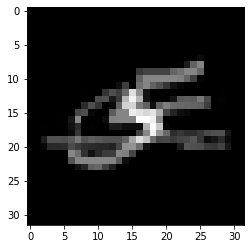

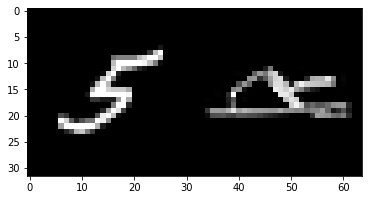

In [7]:
x, y = next(train_generator)
plt.imshow(x[0],cmap='gray', interpolation='nearest',)
plt.show()
plt.imshow(y[0], cmap='gray', interpolation='nearest')
plt.show()

# MODEL

The U-Net is an elegant architecture and is maybe the most known network architecture used for segmentation. It uses the concept of fully convolutional networks for this approach and its intent is to capture both the features of the context as well as the localization. The main idea of the implementation is to utilize successive contracting layers, which are immediately followed by the upsampling operators for achieving higher resolution outputs on the input images.

So, as a first attempt I tried using a single U-Net taking the cue from the **03/05/2022 Segmentation Laboratory** since the given task looks like an image segmentation problem. However, since we want as ouput an image that is a concatenation of two images coming from different datasets, the idea that led to better results was to use two U-Net in parallel where each of them  focuses on classify and localize pixels coming from a specific dataset (mnist and fashion_mnist) and then the two outputs, coming from the two U-Net are concatenated in order to produce the final 32x64 image composed by the images of the respective datasets.

After several attempts, I decided to slightly modify the U-Net networks. In particular:

* Another 2 convolution layers per floor have been added (instead of the original 2) for a total of 4 convolution layers for each floor.

* After the four convolution layers per floor, a batchnormalization layer has been added, to make the network more stable and speed up the convergence time.

These changes from the original model were made to gain the best outcomes possible.

In [8]:
def build_unet(input, n_ch=32, L=4, conv_per_L=2):
    
    # ENCODER
    backup_layers = []
    h = input
    for l in range(L):

        # Each floor in the descent phase
        for c in range(conv_per_L):
            h = ks.layers.Conv2D(n_ch, 3, 1, padding='same')(h)
            h = ks.layers.ReLU()(h)

        h = layers.BatchNormalization()(h, training=False)
            
        if l < L-1:
            # Downsample
            backup_layers.append(h) 
            h = ks.layers.MaxPool2D(padding='same')(h)

            # Update the channels
            n_ch = n_ch * 2

    
    # DECODER
    for l in range(L-1):
        # Reduce the channels
        n_ch = n_ch // 2

        # Upsample
        h = ks.layers.Conv2DTranspose(n_ch,2, 2, padding='same')(h)

        # Concatenate
        h = ks.layers.concatenate([h, backup_layers.pop(-1)])
        
        # Each floor in the up phase
        for c in range(conv_per_L):
            h = ks.layers.Conv2D(n_ch, 3, 1, padding='same')(h)
            h = ks.layers.ReLU()(h)
        
        h = layers.BatchNormalization()(h, training=False)
        
    # Output
    y = ks.layers.Conv2D(1, 1)(h)
    
    return y

In this case we start with an imput image 32x32x1 and we apply a certain number of filters, whose value is set to 64, n_ch=64. As said above, the 4 convolutional layers per floor, each followed by a ReLu activation layer so that all the negative values are not passed to the next layer, are followed along by the Batch Normalization layer. This is done for a total of 3 floors. 
Then after creating the two nets, their outputs are Concatenated and then the model is builted.
As optimizer, Adam was used as it is a common choice and as loss function I used the mean absolute error.

In [17]:
x = ks.layers.Input(shape=inputShape,name='input')
y1 = build_unet(x,n_ch=64,L=3,conv_per_L=4)
y2 = build_unet(x,n_ch=64,L=3,conv_per_L=4)
double_unet = layers.Concatenate(axis=2)([y1,y2])
model = ks.Model(x,double_unet)

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='mae',
                  metrics=['mse'])
display(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_22 (Conv2D)             (None, 32, 32, 64)   640         ['input[0][0]']                  
                                                                                                  
 conv2d_43 (Conv2D)             (None, 32, 32, 64)   640         ['input[0][0]']                  
                                                                                                  
 re_lu_20 (ReLU)                (None, 32, 32, 64)   0           ['conv2d_22[0][0]']              
                                                                                            

None

# Training the Model
The model has been trained considering an EarlyStopping callback in order to avoid wasting time when the model tends to overfit and to recover the best obtained weights.
In addition I used the ReduceLROnPlateu callback, starting from an initial value of `lr=1e-3`, with a reduction factor set to 0.5 in order to reduce the learning rate when the metric has stopped improving.


In [19]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-6, restore_best_weights=True)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5,patience=5,verbose=1,mode="min",min_delta=1e-4,cooldown=0,min_lr=0,)
my_callbacks = [es, lr]

Then, the following settings regarding epochs,step_per_epochs and validation_steps were made.

In [20]:
steps_per_epoch=500
validation_steps=10

history=model.fit(
    x=train_generator,
    epochs=200,
    steps_per_epoch=steps_per_epoch,
    callbacks=my_callbacks,
    validation_data = val_generator,
    validation_steps = validation_steps
)

Epoch 1/200
500/500 [==============================] - 64s 122ms/step - loss: 0.0379 - mse: 0.0131 - val_loss: 0.0155 - val_mse: 0.0027 - lr: 0.0010
Epoch 2/200
500/500 [==============================] - 61s 121ms/step - loss: 0.0140 - mse: 0.0022 - val_loss: 0.0104 - val_mse: 0.0014 - lr: 0.0010
Epoch 3/200
500/500 [==============================] - 61s 121ms/step - loss: 0.0107 - mse: 0.0015 - val_loss: 0.0094 - val_mse: 0.0013 - lr: 0.0010
Epoch 4/200
500/500 [==============================] - 61s 121ms/step - loss: 0.0098 - mse: 0.0012 - val_loss: 0.0084 - val_mse: 0.0011 - lr: 0.0010
Epoch 5/200
500/500 [==============================] - 61s 121ms/step - loss: 0.0092 - mse: 0.0011 - val_loss: 0.0135 - val_mse: 0.0016 - lr: 0.0010
Epoch 6/200
500/500 [==============================] - 61s 121ms/step - loss: 0.0089 - mse: 0.0010 - val_loss: 0.0088 - val_mse: 0.0010 - lr: 0.0010
Epoch 7/200
500/500 [==============================] - 61s 121ms/step - loss: 0.0080 - mse: 9.2327e-04 - v

After training, I plot the results of the loss and of the mean_squared_error during training.

In [40]:
def plot_history(model_history,keys):
  m,val_m= keys
  history = model_history.history[m]
  val_history = model_history.history[val_m]

  df = pd.DataFrame(dict(
      x = range(1,len(history)+1),
      y = history, 
      y_1 = val_history,
      ))

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=df['x'], y=df['y'],
                    mode='lines+markers',
                    name= m))

  fig.add_trace(go.Scatter(x=df['x'], y=df['y_1'],
                    mode='lines+markers',
                    name= val_m))

  fig.update_layout(
      title = m + ' during training',
      legend_title='Losses',
      xaxis_title = 'Epochs'
      )

  fig.update_xaxes()
  fig.show()


plot_history(history,['loss','val_loss'])
plot_history(history,['mse','val_mse'])


*Loss* and *validation loss*, after a short period in which the val_loss fluctuates a bit, start drecrease together, showing that the model is learning and is not affected by overfitting. Also from the plot of *mse* and *val_mse*, we can see that the model has comparable performance on both train and validation datasets. 
So it can be seen also that the system starts to get good performance when training at about the 30th epoch. We are now going to save our results and see how the network behaves on a batch of photos.

In [44]:
# cell to save weights after learning the net
model.save_weights("exam_weights.h5")

# Model Testing and Conclusions
Once the network is trained we can see how it behaves with the test data passed through the *test_generator*.

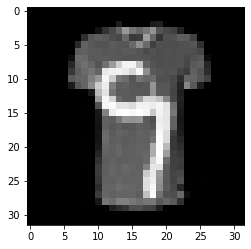

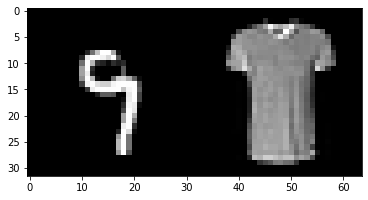

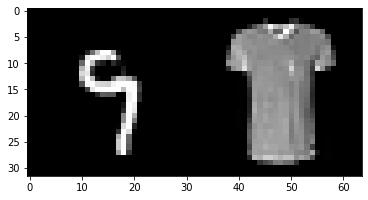

In [26]:
#getting predictions
x_test,y_test=next(test_generator)
y_pred=model.predict(x_test)

#plot of input and predicted images
plt.imshow(x_test[0],cmap='gray')
plt.show()
plt.imshow(y_test[0],cmap='gray')
plt.show()
plt.imshow(y_pred[0].reshape(32,64).astype(np.float32),cmap='gray')
plt.show()

It's possible to see that the predicted image it's pretty much the same as the real label image. Now, after defining the following functions for computing the results in terms of mse, we can evaluate the mse over 20000 samples and repeat the computation 10 times in order to check the standard deviation.

In [27]:
def mse(y, y_pred):
    m = ks.metrics.MeanSquaredError()
    m.update_state(y, y_pred)
    return m.result().numpy()

def compute_metrics(original, noisy, metrics):
    results = {}
    for name, metric in metrics.items():
        results[name] = metric(original, noisy)
    return results

def evaluate_model(model, x, y, metrics):
    y_pred = model.predict(x) 
    x = x.astype('float32')
    y_pred = y_pred.astype('float32')
    y = y.astype('float32')
  
    results = mse(y,y_pred)
    return results


In [28]:
results = []
for i in range(10):
  x, y = next(test_generator)
  results.append(evaluate_model(model, x, y, mse))

print(results)

print("mean: ", np.mean(results))
print("std: ", np.std(results))

[0.0004455631, 0.00044086485, 0.00043797263, 0.00043911606, 0.0004400878, 0.0004386296, 0.0004382626, 0.00043205376, 0.0004392267, 0.0004396286]
mean:  0.00043914057
std:  3.1302498e-06


In cocnlusion, with the double U-Net I reached very good values in terms of mean-squared-error and standard deviation indeed they are very small values. 
Furthermore, during various attempts I noticed how, by reloading the weights and performing new training sessions, the results improve reaching even the best value of mse equal to `3.8e-04` but then the network starts overfitting.